In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
from utils_unet_resunet import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from model.models import Model_3
from model.losses import WBCE
root_path = 'imgs/' 

In [8]:
# Define data type (L8-Landsat8, S2-Sentinel2, S1-Sentinel1)
img_type = 'SAR'

if img_type == 'FUSION':
    image_array = np.load(root_path+'New_Images/fus_stack.npy')
    

if img_type == 'OPT':
    image_array = np.load(root_path+'New_Images/opt_stack.npy')
    
    
if img_type == 'SAR':
    image_array = np.load(root_path+'New_Images/sar_stack.npy')
print('Image stack:', image_stack.shape)

final_mask1 = np.load(root_path+'New_Images/'+'final_mask1.npy')
print('Labels stack:', final_mask1.shape)

Image stack: (10000, 7000, 4)
Labels stack: (10000, 7000)


In [18]:
h_, w_, channels = image_array.shape
patch_size = 128

In [10]:
# Create tile mask
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
#plt.imshow(mask_tiles)

Tiles size:  2000 1750
Mask size:  (10000, 7000)
mask:  (10000, 7000)
image stack:  (10000, 7000, 4)
ref : (10000, 7000)


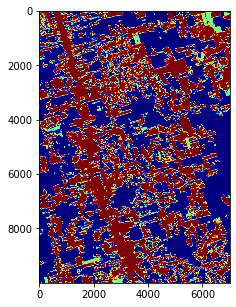

In [11]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

In [12]:
# Define tiles for training, validation, and test sets
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_tr_val = np.zeros((mask_tiles.shape)).astype('float32')
# Training and validation mask
for tr_ in tiles_tr:
    mask_tr_val[mask_tiles == tr_] = 1

for val_ in tiles_val:
    mask_tr_val[mask_tiles == val_] = 2

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

In [13]:
# Create ixd image to extract patches
overlap = 0.7
patch_size = 128
batch_size = 32
im_idx = create_idx_image(final_mask1)
patches_idx = extract_patches(im_idx, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1,patch_size, patch_size)
patches_mask = extract_patches(mask_tr_val, patch_size=(patch_size, patch_size), overlap=overlap).reshape(-1, patch_size, patch_size)
del im_idx

In [14]:
# Selecting index trn val and test patches idx
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==patch_size**2))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*patch_size**2))
del patches_mask

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
del idx_trn, idx_val

print('Number of training patches:  ', len(patches_idx_trn), 'Number of validation patches', len(patches_idx_val))

Number of training patches:   17110 Number of validation patches 4116


In [15]:
# Extract patches with at least 2% of deforestation class
X_train = retrieve_idx_percentage(final_mask1, patches_idx_trn, patch_size, pertentage = 2)
X_valid = retrieve_idx_percentage(final_mask1, patches_idx_val, patch_size, pertentage = 2)
print(X_train.shape, X_valid.shape)
del patches_idx_trn, patches_idx_val

(1158, 128, 128) (341, 128, 128)


In [16]:
def batch_generator(batches, image, reference, target_size, number_class):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    image = image.reshape(-1, image.shape[-1])
    reference = reference.reshape(final_mask1.shape[0]*final_mask1.shape[1])
    while True:
        batch_x, batch_y = next(batches)
        batch_x = np.squeeze(batch_x.astype('int64'))
        #print(batch_x.shape)
        batch_img = np.zeros((batch_x.shape[0], target_size, target_size, image.shape[-1]))
        batch_ref = np.zeros((batch_x.shape[0], target_size, target_size, number_class))
        
        for i in range(batch_x.shape[0]):
            if np.random.rand()>0.5:
                batch_x[i] = np.rot90(batch_x[i], 1)
            batch_img[i] = image[batch_x[i]] 
            batch_ref[i] = tf.keras.utils.to_categorical(reference[batch_x[i]] , number_class)
                       
        yield (batch_img, batch_ref)

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = True)
valid_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True)

y_train = np.zeros((len(X_train)))
y_valid = np.zeros((len(X_valid)))

train_gen = train_datagen.flow(np.expand_dims(X_train, axis = -1), y_train,
                              batch_size=batch_size,
                              shuffle=True)

valid_gen = valid_datagen.flow(np.expand_dims(X_valid, axis = -1), y_valid,
                              batch_size=batch_size,
                              shuffle=False)

number_class = 3
train_gen_crops = batch_generator(train_gen, image_array, final_mask1, patch_size, number_class)
valid_gen_crops = batch_generator(valid_gen, image_array, final_mask1, patch_size, number_class)


In [19]:
exp = 1
path_exp = root_path+'experiments/exp'+str(exp)
path_models = path_exp+'/models'
path_maps = path_exp+'/pred_maps'

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [20]:
# Define model
input_shape = (patch_size, patch_size, channels)
nb_filters = [32, 64, 128]

method = 'unet'
if method == 'unet':
   model = build_unet(input_shape, nb_filters, number_class)

if method == 'resunet':
   model = build_resunet(input_shape, nb_filters, number_class)

#model = Model_3(nb_filters, number_class)

In [21]:
# Parameters of the model
weights = [0.2, 0.8, 0]
adam = Adam(lr = 1e-3 , beta_1=0.9)
loss = weighted_categorical_crossentropy(weights)
#loss = WBCE(weights = weights)
#loss = WBCE(weights = weights, class_indexes = [0, 1])


In [22]:
metrics_all = []
times=5
for tm in range(0,times):
    print('time: ', tm)

    rows = patch_size
    cols = patch_size
    adam = Adam(lr = 1e-3 , beta_1=0.9)
    loss = weighted_categorical_crossentropy(weights)
    #loss = WBCE(weights = weights)
    #loss = WBCE(weights = weights, class_indexes = [0, 1])

    #if method == 'unet':
    #   model = build_unet(input_shape, nb_filters, number_class)

    #if method == 'resunet':
    #   model = build_resunet(input_shape, nb_filters, number_class)
    
    #model = Model_3(nb_filters, number_class)
    #model.build((None,)+input_shape)
    model = build_unet(input_shape, nb_filters, number_class)
    
    model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
    model.summary()

    earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    #earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min') ---- val_accuracy
    checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    #checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
    lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
    callbacks_list = [earlystop, checkpoint]
    # train the model
    start_training = time.time()
    history = model.fit(train_gen_crops,
                              steps_per_epoch=len(X_train)*3//train_gen.batch_size,
                              validation_data=valid_gen_crops,
                              validation_steps=len(X_valid)*3//valid_gen.batch_size,
                              epochs=100,
                              callbacks=callbacks_list)
    end_training = time.time() - start_training
    metrics_all.append(end_training)
    del model, history

time:  0
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 4) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 32) 1184        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 64, 64)   18496       max_pooling2d_3[0][0]            
___________________________________________________________________________________

108/108 [==============================] - 6s 46ms/step - loss: 0.1314 - accuracy: 0.6423 - val_loss: 0.1189 - val_accuracy: 0.6973

Epoch 00001: val_loss improved from inf to 0.11890, saving model to imgs/experiments/exp1/models\unet_1.h5
Epoch 2/100
108/108 [==============================] - 5s 44ms/step - loss: 0.1116 - accuracy: 0.6967 - val_loss: 0.1062 - val_accuracy: 0.7079

Epoch 00002: val_loss improved from 0.11890 to 0.10619, saving model to imgs/experiments/exp1/models\unet_1.h5
Epoch 3/100
108/108 [==============================] - 5s 44ms/step - loss: 0.0977 - accuracy: 0.7287 - val_loss: 0.1207 - val_accuracy: 0.6974

Epoch 00003: val_loss did not improve from 0.10619
Epoch 4/100
108/108 [==============================] - 5s 45ms/step - loss: 0.0921 - accuracy: 0.7463 - val_loss: 0.1184 - val_accuracy: 0.7082

Epoch 00004: val_loss did not improve from 0.10619
Epoch 5/100
108/108 [==============================] - 5s 45ms/step - loss: 0.0888 - accuracy: 0.7541 - val_loss

108/108 [==============================] - 6s 59ms/step - loss: 0.0887 - accuracy: 0.7569 - val_loss: 0.1221 - val_accuracy: 0.7184

Epoch 00005: val_loss did not improve from 0.11533
Epoch 6/100
108/108 [==============================] - 6s 60ms/step - loss: 0.0857 - accuracy: 0.7641 - val_loss: 0.1260 - val_accuracy: 0.7254

Epoch 00006: val_loss did not improve from 0.11533
Epoch 7/100
108/108 [==============================] - 7s 61ms/step - loss: 0.0841 - accuracy: 0.7685 - val_loss: 0.1181 - val_accuracy: 0.7050

Epoch 00007: val_loss did not improve from 0.11533
Epoch 8/100
108/108 [==============================] - 7s 61ms/step - loss: 0.0777 - accuracy: 0.7794 - val_loss: 0.1232 - val_accuracy: 0.7235

Epoch 00008: val_loss did not improve from 0.11533
Epoch 9/100
108/108 [==============================] - 7s 62ms/step - loss: 0.0715 - accuracy: 0.7936 - val_loss: 0.1216 - val_accuracy: 0.7283

Epoch 00009: val_loss did not improve from 0.11533
Epoch 10/100
108/108 [==========

108/108 [==============================] - 7s 65ms/step - loss: 0.0764 - accuracy: 0.7818 - val_loss: 0.1229 - val_accuracy: 0.7257

Epoch 00009: val_loss did not improve from 0.11134
Epoch 10/100
108/108 [==============================] - 7s 65ms/step - loss: 0.0703 - accuracy: 0.7922 - val_loss: 0.1202 - val_accuracy: 0.7158

Epoch 00010: val_loss did not improve from 0.11134
Epoch 11/100
108/108 [==============================] - 7s 66ms/step - loss: 0.0671 - accuracy: 0.8006 - val_loss: 0.1296 - val_accuracy: 0.7205

Epoch 00011: val_loss did not improve from 0.11134
Epoch 12/100
108/108 [==============================] - 7s 67ms/step - loss: 0.0615 - accuracy: 0.8103 - val_loss: 0.1422 - val_accuracy: 0.7129

Epoch 00012: val_loss did not improve from 0.11134
Epoch 13/100
108/108 [==============================] - 7s 67ms/step - loss: 0.0575 - accuracy: 0.8191 - val_loss: 0.1446 - val_accuracy: 0.7205

Epoch 00013: val_loss did not improve from 0.11134
Epoch 14/100
108/108 [======

108/108 [==============================] - 7s 67ms/step - loss: 0.0798 - accuracy: 0.7711 - val_loss: 0.1264 - val_accuracy: 0.7189

Epoch 00008: val_loss did not improve from 0.10841
Epoch 9/100
108/108 [==============================] - 7s 69ms/step - loss: 0.0743 - accuracy: 0.7854 - val_loss: 0.1266 - val_accuracy: 0.7240

Epoch 00009: val_loss did not improve from 0.10841
Epoch 10/100
108/108 [==============================] - 7s 68ms/step - loss: 0.0680 - accuracy: 0.7973 - val_loss: 0.1293 - val_accuracy: 0.7146

Epoch 00010: val_loss did not improve from 0.10841
Epoch 11/100
108/108 [==============================] - 7s 69ms/step - loss: 0.0652 - accuracy: 0.8012 - val_loss: 0.1395 - val_accuracy: 0.7233

Epoch 00011: val_loss did not improve from 0.10841
Epoch 12/100
108/108 [==============================] - 7s 69ms/step - loss: 0.0596 - accuracy: 0.8125 - val_loss: 0.1430 - val_accuracy: 0.7250

Epoch 00012: val_loss did not improve from 0.10841
Epoch 13/100
108/108 [=======

In [23]:
# Test loop
time_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_array.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_array, pad_width=npad, mode='reflect')

h, w, c = image1_pad.shape
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)

input_shape=(patch_size_rows,patch_size_cols, c)

if method == 'unet':
   new_model = build_unet(input_shape, nb_filters, number_class)

#if method == 'resunet':
#   new_model = build_resunet(input_shape, nb_filters, number_class)

#new_model = Model_3(nb_filters, number_class)
#new_model.build((None,)+input_shape)

for tm in range(0,times):
    print('time: ', tm)
    model = load_model(path_models+ '/' + method +'_'+str(tm)+'.h5', compile=False)
    
    for l in range(1, len(model.layers)):
        new_model.layers[l].set_weights(model.layers[l].get_weights())
    #new_model.load_weights(path_models+ '/' + method +'_'+str(tm)+'.h5')
    
    start_test = time.time()
    patch_t = []
    
    for i in range(0,num_patches_y):
        for j in range(0,num_patches_x):
            patch = image1_pad[patch_size_rows*j:patch_size_rows*(j+1), patch_size_cols*i:patch_size_cols*(i+1), :]
            predictions_ = new_model.predict(np.expand_dims(patch, axis=0))
            del patch 
            patch_t.append(predictions_[:,:,:,1])
            del predictions_
    end_test =  time.time() - start_test
    patches_pred = np.asarray(patch_t).astype(np.float32)

    prob_recontructed = pred_reconctruct(h, w, num_patches_x, num_patches_y, patch_size_rows, patch_size_cols, patches_pred)
    np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_recontructed) 

    time_ts.append(end_test)
    del prob_recontructed, patches_pred
    #del model
time_ts_array = np.asarray(time_ts)
# Save test time
np.save(path_exp+'/metrics_ts.npy', time_ts_array)


0.0 -8.0
time:  0
time:  1
time:  2
time:  3
time:  4


In [24]:
# Compute mean of the tm predictions maps
prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], times))

for tm in range (0, times):
    print(tm)
    prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)

mean_prob = np.mean(prob_rec, axis = -1)
np.save(path_maps+'/prob_mean.npy', mean_prob)

0
1
2
3
4


(-0.5, 6999.5, 9999.5, -0.5)

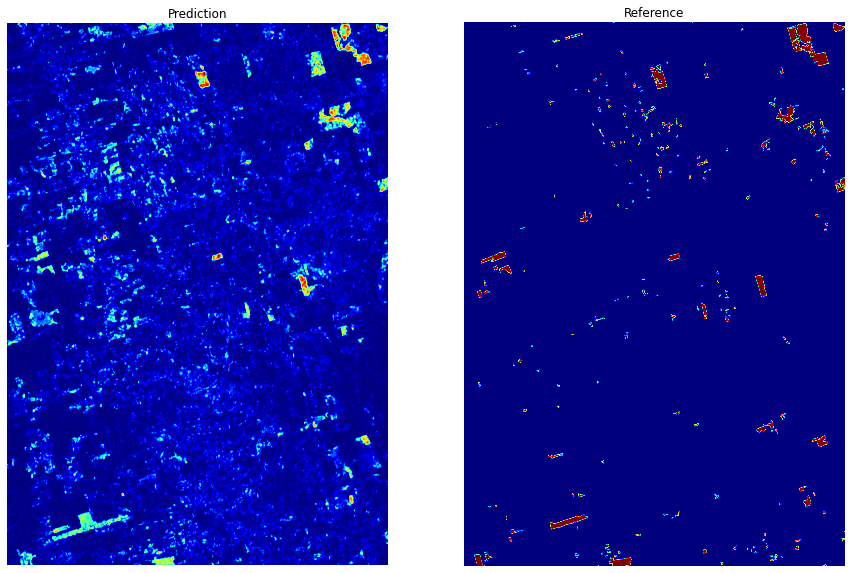

In [25]:
# Plot mean map and reference
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121)
plt.title('Prediction')
ax1.imshow(mean_prob, cmap ='jet')
ax1.axis('off')


ax2 = fig.add_subplot(122)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [26]:
# Computing metrics
mean_prob = mean_prob[:final_mask1.shape[0], :final_mask1.shape[1]]
ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50
Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)
    
metrics_ = matrics_AA_recall(ProbList, mean_prob, final_mask1, mask_amazon_ts, 625)
np.save(path_exp+'/acc_metrics.npy',metrics_)

0.9262629389762879


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.9073596136910576


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.8884562884058271


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.8695529631205967


D:\Ferrari\proj_1\projeto\utils_unet_resunet.py:200: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_ = TP/(TP+FP)


0.8506496378353664
0.8317463125501361
0.8128429872649057
0.7939396619796752
0.7750363366944449
0.7561330114092146
0.7372296861239842
0.7183263608387538
0.6994230355535235
0.6805197102682932
0.6616163849830627
0.6427130596978323
0.623809734412602
0.6049064091273717
0.5860030838421413
0.5670997585569109
0.5481964332716805
0.5292931079864502
0.5103897827012198
0.49148645741598945
0.4725831321307591
0.4536798068455287
0.43477648156029836
0.41587315627506805
0.3969698309898376
0.3780665057046072
0.3591631804193769
0.3402598551341466
0.32135652984891616
0.30245320456368574
0.28354987927845543
0.2646465539932251
0.2457432287079947
0.22683990342276428
0.20793657813753397
0.18903325285230366
0.17012992756707324
0.15122660228184281
0.1323232769966125
0.1134199517113822
0.09451662642615177
0.07561330114092135
0.05670997585569104
0.03780665057046073
0.01890332528523031
0.0


In [27]:
# Complete NaN values
metrics_copy = metrics_.copy()
metrics_copy = complete_nan_values(metrics_copy)

mAP 0.8315402453182716


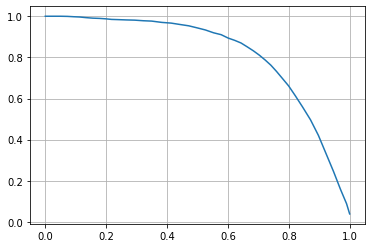

In [28]:
# Comput Mean Average Precision (mAP) score 
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]
AA = metrics_copy[:,2]
    
DeltaR = Recall[1:]-Recall[:-1]
AP = np.sum(Precision[:-1]*DeltaR)
print('mAP', AP)

# Plot Recall vs. Precision curve
plt.close('all')
plt.plot(metrics_copy[:,0],metrics_copy[:,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()